In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import schur, eigvals, eig

# Phase diagram in composition plane in the absence of nonlocal terms

## Eequations for density and polarity fields

$$
\begin{aligned}
    \partial_t \rho_S &= -\nabla \cdot (v_S \mathbf{p}_S) + D_t\Delta \rho_S,\\
    \partial_t \mathbf{p}_S &= \frac{v_S}{16D_r} \Delta (v_S\mathbf{p}_S) - \frac{1}{2} \nabla (v_S \rho_S) - D_r \mathbf{p}_S + D_t\Delta\mathbf{p}_S,
\end{aligned}
$$
where $v_S$ is determined by
$$
v_S(\rho_A(\mathbf{r}), \rho_B(\mathbf{r})) = \bar{v}_{S} \tilde{v}_{SA}(\rho_A(\mathbf{r}))\tilde{v}_{SB}(\rho_B(\mathbf{r})),
$$
with
$$
\begin{aligned}
\tilde{v}_{SA}(\rho_A(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SA}}{\kappa}\frac{\rho_A(\mathbf{r})-\bar{\rho}_A}{\rho_0}
	\right),\\
\tilde{v}_{SB}(\rho_B(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SB}}{\kappa}\frac{\rho_B(\mathbf{r})-\bar{\rho}_B}{\rho_0}
	\right).
\end{aligned}
$$

The spatial gradient of $v_S(\mathbf{r})$ is
$$
\begin{aligned}
\nabla v_S &= \bar{v}_S \left(
    \tilde{v}_{SB}\nabla \tilde{v}_{SA}+\tilde{v}_{SA}\nabla \tilde{v}_{SB}
\right) \\
&= \bar{v}_S \left(
    \tilde{v}_{SA}' \tilde{v}_{SB}\nabla \rho_A +
    \tilde{v}_{SA} \tilde{v}_{SB}'\nabla \rho_B
\right) \\
&= v_S \left(
    \frac{\tilde{v}'_{SA}}{\tilde{v}_{SA}} \nabla \rho_A +
    \frac{\tilde{v}'_{SB}}{\tilde{v}_{SB}} \nabla \rho_B
\right),
\end{aligned}
$$
where
$$
\begin{aligned}
\tilde{v}_{SA}'&=\partial_{\rho_A} \tilde{v}_{SA} = \frac{\eta_{SA}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SA}}{\kappa}\frac{\rho_A-\bar{\rho}_A}{\rho_0}\right)\right] = \frac{\eta_{SA}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SA}-1}{\kappa}\right)^2
\right],\\
\tilde{v}_{SB}'&=\partial_{\rho_B} \tilde{v}_{SB} = \frac{\eta_{SB}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SB}}{\kappa}\frac{\rho_B-\bar{\rho}_B}{\rho_0}\right)\right] = \frac{\eta_{SB}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SB}-1}{\kappa}\right)^2
\right].
\end{aligned}
$$

<!-- Futhermore, the Laplacian of $v_S$ can be written as
$$
\nabla^2 v_S \approx v_S \left(
    \frac{\tilde{v}'_{SA}}{\tilde{v}_{SA}} \nabla^2 \rho_A +
    \frac{\tilde{v}'_{SB}}{\tilde{v}_{SB}} \nabla^2 \rho_B
\right),
$$
where the nonlinear terms has been ommited. -->

In [2]:
def get_tilde_v_XY(eta_XY, rho_Y, bar_rho_Y, kappa=0.7):
    return 1 + kappa * np.tanh(eta_XY/kappa * (rho_Y - bar_rho_Y))

def get_tilde_v(eta_AA, eta_AB, eta_BA, eta_BB, rho_A, rho_B, bar_rho_A, bar_rho_B, kappa=0.7):
    drho_A = rho_A - bar_rho_A
    drho_B = rho_B - bar_rho_B
    inv_kappa = 1. / kappa
    v_AA = 1 + kappa * np.tanh(eta_AA * inv_kappa * drho_A)
    v_AB = 1 + kappa * np.tanh(eta_AB * inv_kappa * drho_B)
    v_BA = 1 + kappa * np.tanh(eta_BA * inv_kappa * drho_A)
    v_BB = 1 + kappa * np.tanh(eta_BB * inv_kappa * drho_B)
    return v_AA, v_AB, v_BA, v_BB

def get_v_A(rho_A, rho_B, bar_rho_A, bar_rho_B, etaAA, etaAB, bar_v_A=1., kappa=0.7):
    v_AA = get_tilde_v_XY(etaAA, rho_A, bar_rho_A, kappa)
    v_AB = get_tilde_v_XY(etaAB, rho_B, bar_rho_B, kappa) 
    return bar_v_A * v_AA * v_AB

def get_v_B(rho_A, rho_B, bar_rho_A, bar_rho_B, etaBA, etaBB, bar_v_B=1., kappa=0.7):
    v_BA = get_tilde_v_XY(etaBA, rho_A, bar_rho_A, kappa)
    v_BB = get_tilde_v_XY(etaBB, rho_B, bar_rho_B, kappa)
    return bar_v_B * v_BA * v_BB

def get_tilde_v_XY_derive(eta_XY, tilde_v_XY, kappa=0.7):
    return eta_XY * (1 - ((tilde_v_XY - 1)/kappa)**2)

## Linear expansion around the homogenous phase

Around the homogenous phase $(\rho_S=\phi_S, \mathbf{p}_S=0)$, the dynamics of fluctuations $\delta \rho_S$ and $\mathbf{p}_S$ are dictated by
$$
\begin{aligned}
	\partial_t \delta \rho_S &= -v_{S,0} \nabla \mathbf{p}_S + D_t \Delta \delta\rho_S,\\
	\partial_t \mathbf{p}_S &= -\left(D_r - \left(D_t + \frac{v_{S,0}^2}{16D_r}\right) \Delta\right)\mathbf{p}_S - \frac{1}{2} (v_{S,0}\nabla \delta \rho_S + \rho_{S,0}\nabla \delta v_S)\\
	&= -\left(D_r - \left(D_t + \frac{v_{S,0}^2}{16D_r}\right) \Delta\right)\mathbf{p}_S - \frac{v_{S,0}}{2} \left(
		\nabla \delta \rho_S + \omega_{SA} \nabla \delta \rho_A + \omega_{SB} \nabla \delta \rho_B
	\right),
\end{aligned}
$$

where
<!-- $$
\omega_{XY} = \rho_{X,0} \left.\left(\frac{\tilde{v}'_{XY}}{\tilde{v}_{XY}}\right)\right|_{\rho_{Y}=\rho_{Y,0}}.
$$ -->
$$
\omega_{SS'} = \frac{\rho_{S,0}}{v_{S,0}} \left.\frac{\partial v_{S}}{\partial \rho_{S'}}\right|_{\rho_{S'}=\rho_{S',0}} =
	\frac{\rho_{S,0}}{\tilde{v}_{SS'}(\rho_{S',0})}\left.\frac{\mathrm{d}\tilde{v}_{SS'}}{\mathrm{d} \rho_{S'}}\right|_{\rho_{S'}=\rho_{S',0}}
$$

In Fourier space, we have
$$
\begin{aligned}
\partial_t \delta \rho_S &= -i v_{S,0} \mathbf{q}\cdot \mathbf{p}_S - D_t q^2 \delta \rho_S, \\
\partial_t \mathbf{p}_S &= -(D_S q + D_t q^2) \mathbf{p}_S - i\frac{v_{S,0}}{2} (\delta \rho_S + \omega_{SA}\delta \rho_A +\omega_{SB}\delta \rho_B)\mathbf{q},
\end{aligned}
$$
where
$$
D_S = \frac{D_r}{q} + \frac{v^2_{S,0}}{16D_r}q.
$$

Therefore,
$$
\begin{aligned}
		\partial_t \begin{pmatrix}
			\delta \rho_A \\ p_A \\ \delta \rho_B \\ p_B
		\end{pmatrix} &=
		q M
		\begin{pmatrix}
			\delta \rho_A \\ p_A \\ \delta \rho_B \\ p_B
		\end{pmatrix}
		-D_t q^2
		\begin{pmatrix}
			\delta \rho_A \\ p_A \\ \delta \rho_B \\ p_B
		\end{pmatrix},
	\end{aligned}
$$
where the matrix $M$ reads
$$
\begin{aligned}
M &= \begin{pmatrix}
	0 & -iv_{A,0} & 0 & 0 \\
	-\frac{iv_{A,0}}{2}(1+\omega_{AA}) & -D_A & -\frac{iv_{A,0}}{2} \omega_{AB} & 0 \\
	0 & 0 & 0 & -iv_{B,0} \\
	-\frac{iv_{B,0}}{2}\omega_{BA} & 0 & -\frac{iv_{B,0}}{2}(1+\omega_{BB}) & -D_B
\end{pmatrix}
\end{aligned}
$$



In [3]:
def get_v0_omega(etaAA, etaAB, etaBA, etaBB, phiA, phiB, bar_rho_A, bar_rho_B, bar_vA=1., bar_vB=1., kappa=0.7):
    v_AA, v_AB, v_BA, v_BB = get_tilde_v(etaAA, etaAB, etaBA, etaBB, phiA, phiB, bar_rho_A, bar_rho_B, kappa)
    vA_0 = bar_vA * v_AA * v_AB
    vB_0 = bar_vB * v_BA * v_BB
    v_AA_deriv = get_tilde_v_XY_derive(etaAA, v_AA)
    v_AB_deriv = get_tilde_v_XY_derive(etaAB, v_AB)
    v_BA_deriv = get_tilde_v_XY_derive(etaBA, v_BA)
    v_BB_deriv = get_tilde_v_XY_derive(etaBB, v_BB)
    omega_AA = phiA * v_AA_deriv / v_AA
    omega_AB = phiA * v_AB_deriv / v_AB
    omega_BA = phiB * v_BA_deriv / v_BA
    omega_BB = phiB * v_BB_deriv / v_BB
    return vA_0, vB_0, omega_AA, omega_AB, omega_BA, omega_BB


class DMatrix:
    def __init__(self, etaAA, etaAB, etaBA, etaBB, phiA, phiB, Dr, bar_rhoA=1., bar_rhoB=1., bar_vA=1., bar_vB=1., kappa=0.7):
        vA_0, vB_0, omega_AA, omega_AB, omega_BA, omega_BB = get_v0_omega(
            etaAA, etaAB, etaBA, etaBB, phiA, phiB, bar_rhoA, bar_rhoB, bar_vA, bar_vB, kappa)
        self.Dr = Dr
        self.vA2_over_16Dr = vA_0 **2 / (16 * Dr)
        self.vB2_over_16Dr = vB_0 ** 2 / (16 * Dr)
        self.M = np.zeros((4, 4), complex)
        self.M[0, 1] = -1j * vA_0
        self.M[1, 0] = -0.5j * vA_0 * (1 + omega_AA)
        # self.M[1, 1] = 
        self.M[1, 2] = -0.5j * vA_0 * omega_AB
        self.M[2, 3] = -1j * vB_0
        self.M[3, 0] = -0.5j * vB_0 * omega_BA
        self.M[3, 2] = -0.5j * vB_0 * (1 + omega_BB)
        # self.M[3, 3] =

    def get_M(self, q):
        M = self.M.copy()
        M[1, 1] = -(self.Dr / q + self.vA2_over_16Dr * q)
        M[3, 3] = -(self.Dr / q + self.vB2_over_16Dr * q)
        # M[1, 1] = -(self.Dr / q)
        # M[3, 3] = -(self.Dr / q)
        return M
    
    def get_lambda(self, q):
        T, Z = schur(self.get_M(q), output="complex")
        eigen_values = np.array([T[0, 0], T[1, 1], T[2, 2], T[3, 3]]) * q
        return eigen_values
    
    def get_lambda_q(self, q_arr):
        lambda_arr = np.array([self.get_lambda(q) for q in q_arr])
        return lambda_arr
    
    def get_max_lambda(self, q_arr):
        lambda_arr = self.get_lambda_q(q_arr)
        max_lambda = lambda_arr.max(axis=1)
        return max_lambda.max()
    
    def get_lambda_max_lambda_q0(self, q_arr):
        lambda_arr = self.get_lambda_q(q_arr)
        max_lambda = lambda_arr.max(axis=1)
        return max_lambda.max(), max_lambda[0].real

    def get_lambda_max_Re_Im_q0(self, q_arr):
        lambda_arr = self.get_lambda_q(q_arr).max(axis=1)
        max_Re_idx = lambda_arr.real.argmax()
        max_Im_idx = np.abs(lambda_arr.imag).argmax()
        max_Re = lambda_arr[max_Re_idx].real
        if lambda_arr[max_Im_idx].real > 0:
            max_Im = np.abs(lambda_arr[max_Im_idx].imag)
        else:
            max_Im = np.abs(lambda_arr[max_Re_idx].imag)
        return max_Re, max_Im, lambda_arr[0].real


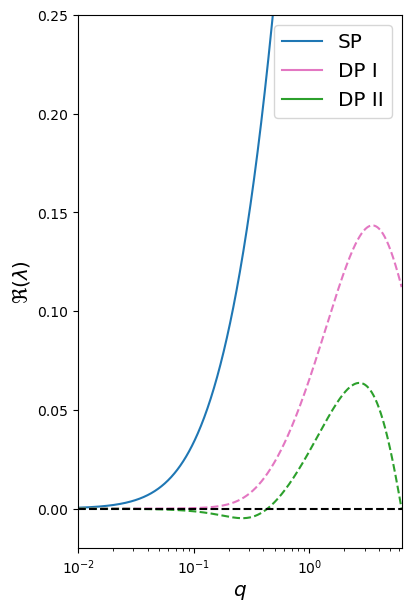

In [4]:
# plot lambda vs q

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 6), constrained_layout=True, sharex=True)

etaAA = -2
etaBB = -2
etaAB = 0.5
etaBA = -etaAB
bar_rho_A = 1
bar_rho_B = 1
Dr = 0.1
Dt = 0.

# phiA = 140/80
phiB = 65/40
q_arr = np.logspace(-2, np.log10(np.pi*2), 1000)
# q_arr = np.logspace(-2, 2, 1000)

# ax2 = ax1.twinx()

clist = ["tab:blue", "tab:pink", "tab:green"]
labels = ["SP", "DP I", "DP II"]
# for phiB in np.linspace(0.48, 0.52, 5, endpoint=True):
for i, phiA in enumerate([50/40, 65/40, 69/40]):
    M = DMatrix(etaAA, etaAB, etaBA, etaBB, phiA, phiB, Dr, bar_rhoA=bar_rho_A, bar_rhoB=bar_rho_B)
    # lambda_arr = M.get_lambda_q(q_arr)
    # print(lambda_arr.shape)
    lambda_arr = M.get_lambda_q(q_arr).max(axis=1)
    
    mask = np.abs(lambda_arr.imag) < 1e-8
    line, = ax1.plot(q_arr[mask], lambda_arr.real[mask] - Dt * q_arr[mask]**2, label=labels[i], c=clist[i])
    mask = np.abs(lambda_arr.imag) >= 1e-8
    line, = ax1.plot(q_arr[mask], lambda_arr.real[mask] - Dt * q_arr[mask]**2, '--', c=clist[i])

    # ax2.plot(q_arr, np.abs(lambda_arr.imag), "--", label=r"%g" % (phiA), c=line.get_c())

ax1.set_xscale("log")
ax1.axhline(0, linestyle="dashed", c="k")
# ax1.set_ylim(-0.1, 0.05)
# ax2.set_xscale("log")
# ax2.legend(title=r"$\phi_B/\rho_0=$", fontsize="large")
ax1.legend(fontsize="x-large")

ax1.set_xlim(q_arr[0], q_arr[-1])
ax1.set_ylim(-0.02, 0.25)
ax1.set_xlabel(r"$q$", fontsize="x-large")
# ax2.set_xlabel(r"$q$", fontsize="large")
ax1.set_ylabel(r"$\Re(\lambda)$", fontsize="x-large")
# ax2.set_ylabel(r"$|\Im(\lambda)|$")

# title = r"$\eta_{AA,BB}=-2,\eta_{AB}=-\eta_{BA}=2, D_r/v_0=0.1, D_t/v_0=%g, \bar{\rho}_{A,B}=\rho_0, \phi_A/\rho_0=1.25$" % Dt
# plt.suptitle(title)
plt.show()
# plt.savefig(f"fig3c.png")
plt.close()


In [14]:
# Phase diagram in (eta_AB, eta_AA) plane


def PD_etaAB_etaAA():
    phiA = 1
    phiB = 0.5
    Dr = 0.1

    qmax = np.pi * 2
    q_arr = np.logspace(-2, np.log10(qmax), 100)


    etaAA_arr = np.linspace(-3, 3, 100, endpoint=True)
    etaAB_arr = np.linspace(0, 4, 100, endpoint=True)

    max_lambda = np.zeros((etaAA_arr.size, etaAB_arr.size), complex)
    lambda0 = np.zeros((etaAA_arr.size, etaAB_arr.size))
    for j, etaAA in enumerate(etaAA_arr):
        etaBB = etaAA
        for i, etaAB in enumerate(etaAB_arr):
            etaBA = -etaAB
            M = DMatrix(etaAA, etaAB, etaBA, etaBB, phiA, phiB, Dr)
            max_lambda[j, i], lambda0[j, i] = M.get_lambda_max_lambda_q0(q_arr)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), constrained_layout=True)
    extent = np.array([etaAB_arr[0], etaAB_arr[-1], etaAA_arr[0], etaAA_arr[-1]])
    im1 = ax1.imshow(max_lambda.real, origin="lower", extent=extent, vmin=-0.2, vmax=0.2, cmap="bwr")
    ax1.contour(etaAB_arr, etaAA_arr, max_lambda.real, levels=[0], colors=["k"])
    plt.colorbar(im1, ax=ax1, orientation="horizontal")

    im2 = ax2.imshow(np.abs(max_lambda.imag), origin="lower", extent=extent)
    ax2.contour(etaAB_arr, etaAA_arr, np.abs(max_lambda.imag), levels=[1e-7], colors=['w'])
    plt.colorbar(im2, ax=ax2, orientation="horizontal")

    im3 = ax3.imshow(lambda0, origin="lower", extent=extent)
    ax3.contour(etaAB_arr, etaAA_arr, lambda0, levels=[0.], colors=['w'])
    plt.colorbar(im3, ax=ax3, orientation="horizontal")

    ax1.contour(etaAB_arr, etaAA_arr, np.abs(max_lambda.imag), levels=[1e-7], colors=['tab:blue'])
    ax1.contour(etaAB_arr, etaAA_arr, lambda0, levels=[0.], colors=['tab:green'])

    plt.show()
    plt.close()

In [13]:
# Phase diagram in (phiA, phiB) plane

def PD_pA_pB(etaAA, etaBB, etaAB, Dr=0.1, bar_rhoA=1, bar_rhoB=1):
    etaBA = -etaAB
    qmax = np.pi * 2
    q_arr = np.logspace(-2, np.log10(qmax), 100)

    if bar_rhoA == 1 and bar_rhoB == 1:
        phiA_arr = np.linspace(0, 5, 150, endpoint=True)
        phiB_arr = np.linspace(0, 5, 150, endpoint=True)
    elif bar_rhoA == 38/40 and bar_rhoB == 8/40:
        phiA_arr = np.linspace(0, 4, 100, endpoint=True)
        phiB_arr = np.linspace(0, 4, 100, endpoint=True)
    else:
        phiA_arr = np.linspace(0, 4, 100, endpoint=True)
        phiB_arr = np.linspace(0, 4, 100, endpoint=True)

    max_lambda = np.zeros((phiB_arr.size, phiA_arr.size), complex)
    lambda0 = np.zeros((phiB_arr.size, phiA_arr.size))
    for j, phiB in enumerate(phiB_arr):
        for i, phiA in enumerate(phiA_arr):
            M = DMatrix(etaAA, etaAB, etaBA, etaBB, phiA, phiB, Dr, bar_rhoA=bar_rhoA, bar_rhoB=bar_rhoB)
            max_lambda[j, i], lambda0[j, i] = M.get_lambda_max_lambda_q0(q_arr)


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), constrained_layout=True)
    extent = np.array([phiA_arr[0], phiA_arr[-1], phiB_arr[0], phiB_arr[-1]]) * 40
    im1 = ax1.imshow(max_lambda.real, origin="lower", extent=extent, vmin=-0.2, vmax=0.2, cmap="bwr")
    ax1.contour(phiA_arr * 40, phiB_arr * 40, max_lambda.real, levels=[0], colors=["k"])
    plt.colorbar(im1, ax=ax1, orientation="horizontal")

    im2 = ax2.imshow(np.abs(max_lambda.imag), origin="lower", extent=extent)
    ax2.contour(phiA_arr * 40, phiB_arr * 40, np.abs(max_lambda.imag), levels=[1e-10], colors=['w'])
    plt.colorbar(im2, ax=ax2, orientation="horizontal")

    im3 = ax3.imshow(lambda0, origin="lower", extent=extent)
    ax3.contour(phiA_arr * 40, phiB_arr * 40, lambda0, levels=[0.], colors=['w'])
    plt.colorbar(im3, ax=ax3, orientation="horizontal")

    ax1.contour(phiA_arr * 40, phiB_arr * 40, np.abs(max_lambda.imag), levels=[1e-10], colors=['tab:blue'])
    ax1.contour(phiA_arr * 40, phiB_arr * 40, lambda0, levels=[0.], colors=['tab:green'])

    title = r"$D_r/v_0=%g,\eta_{AA}=%g,\eta_{BB}=%g,\eta_{AB}=-\eta_{BA}=%g$" % (Dr, etaAA, etaBB, etaAB)
    fig.suptitle(title, fontsize="x-large")
    plt.show()
    plt.close()

    # fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
    # extent = np.array([phiA_arr[0], phiA_arr[-1], phiB_arr[0], phiB_arr[-1]])
    # ax.contour(phiA_arr, phiB_arr, max_lambda.real, levels=[0], colors=["k"])
    # ax.contour(phiA_arr, phiB_arr, np.abs(max_lambda.imag), levels=[1e-7], colors=['tab:red'])
    # ax.contour(phiA_arr, phiB_arr, lambda0, levels=[0.], colors=['tab:green'])
    # ax.set_xlabel(r"$\phi_A/\rho_0$", fontsize="x-large")
    # ax.set_ylabel(r"$\phi_B/\rho_0$", fontsize="x-large")
    # title = r"$D_r/v_0=%g,\eta=%g,\eta_{AB}=-\eta_{BA}=%g,\bar{\rho}_{A,B}=\rho_0$" % (Dr, eta, etaAB)
    # fig.suptitle(title, fontsize="x-large")
    # plt.savefig(f"fig/PD_J{etaAB:g}_e{eta:.3f}.png")
    # # plt.show()
    # plt.close()

# etaAB = 0.75
# for eta in [0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1]:
#     PD_pA_pB(eta, etaAB)
# PD_pA_pB(-1.975, -1.37, 1.905, Dr=3, bar_rhoA=1.153, bar_rhoB=1.295)
# PD_pA_pB(-1.975, -1.37, 1.905, Dr=0.1, bar_rhoA=1.153, bar_rhoB=1.295)


In [9]:
def PD_pA_pB_varied_eta(etaAB):
    if etaAB == 0.5:
        eta_arr = [0, -0.1, -0.3, -0.38, -0.4, -0.42, -0.45, -0.5, -0.6, -0.7, -0.8, -0.9, -1, -1.5, -2, -3]
        p_max = 5
    elif etaAB == 2:
        eta_arr = [0, -0.39, -0.393, -0.396, -0.40, -0.42, -0.44, -0.46, -0.48, -0.5, -0.53, -0.56, -0.6, -1, -2, -3]
        p_max = 4
    etaBA = -etaAB

    bar_rhoA = 40 / 40
    bar_rhoB = 40 / 40
    Dr = 0.1

    qmax = np.pi * 2
    q_arr = np.logspace(-2, np.log10(qmax), 100)

    phiA_arr = np.linspace(0, p_max, 300, endpoint=True)
    phiB_arr = np.linspace(0, p_max, 300, endpoint=True)
    # max_lambda = np.zeros((phiB_arr.size, phiA_arr.size), complex)
    max_Re, max_Im = np.zeros((2, phiB_arr.size, phiA_arr.size))
    lambda0 = np.zeros((phiB_arr.size, phiA_arr.size))

    ncols = 4
    nrows = 4
    if ncols==2 and nrows==1:
        figsize = (8, 5)
    else: 
        figsize = (ncols *4, nrows * 4.2 + 1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True, sharex=True, sharey=True)
    extent = np.array([phiA_arr[0], phiA_arr[-1], phiB_arr[0], phiB_arr[-1]])

    for i_ax, ax in enumerate(axes.flat):
        etaAA = etaBB = eta_arr[i_ax]
        for j, phiB in enumerate(phiB_arr):
            for i, phiA in enumerate(phiA_arr):
                M = DMatrix(etaAA, etaAB, etaBA, etaBB, phiA, phiB, Dr, bar_rhoA=bar_rhoA, bar_rhoB=bar_rhoB)
                # max_lambda[j, i], lambda0[j, i] = M.get_lambda_max_lambda_q0(q_arr)
                max_Re[j, i], max_Im[j, i], lambda0[j, i] = M.get_lambda_max_Re_Im_q0(q_arr)
        ax.contour(phiA_arr, phiB_arr, max_Re, levels=[0], colors=["k"])
        ax.contour(phiA_arr, phiB_arr, max_Im, levels=[1e-10], colors=['tab:red'])
        ax.contour(phiA_arr, phiB_arr, lambda0, levels=[0.], colors=['tab:green'])
        if i_ax % ncols == 0:
            ax.set_ylabel(r"$\phi_B/\rho_0$", fontsize="x-large")
        # elif i_ax % ncols == ncols - 1:
        #     ax.legend()
        if i_ax // ncols == nrows - 1:
            ax.set_xlabel(r"$\phi_A/\rho_0$", fontsize="x-large")
        ax.set_title(r"$\eta=%g$" % etaAA)
    title = r"$D_r/v_0=%g,\eta_{AB}=-\eta_{BA}=%g,\bar{\rho}_{A,B}=\rho_0$" % (Dr, etaAB)
    fig.suptitle(title, fontsize="xx-large")
    # plt.savefig(f"PD_varied_eta_J{etaAB:g}.png")
    plt.show()
    plt.close()

# PD_pA_pB_varied_eta(etaAB=0.5)
# PD_pA_pB_varied_eta(etaAB=2)


In [10]:
def PD_pA_pB_varied_etaAB():
    eta = -2
    etaAB_arr = np.array([0, 0.1, 0.25, 0.5, 1, 2, 3, 4])
    # etaAB_arr = np.arange(12) * 0.05 + 0.5

    # pA_lim = [0.75, 1.75]
    # pB_lim = [0, 1]
    pA_lim = [0, 3]
    pB_lim = [0, 3]
    # etaAB = 2
    # eta_arr = [0, -0.1, -0.2, -0.3, -0.4, -0.45, -0.5, -0.6, -0.8, -1, -1.5, -2]
    # p_max = 4
    # etaBA = -etaAB

    bar_rhoA = 40 / 40
    bar_rhoB = 40 / 40
    Dr = 0.1

    qmax = np.pi * 2
    q_arr = np.logspace(-2, np.log10(qmax), 100)

    phiA_arr = np.linspace(pA_lim[0], pA_lim[1], 300, endpoint=True)
    phiB_arr = np.linspace(pB_lim[0], pB_lim[1], 300, endpoint=True)
    # max_lambda = np.zeros((phiB_arr.size, phiA_arr.size), complex)
    max_Re, max_Im = np.zeros((2, phiB_arr.size, phiA_arr.size))
    lambda0 = np.zeros((phiB_arr.size, phiA_arr.size))

    ncols = 4
    nrows = etaAB_arr.size // ncols
    if ncols==2 and nrows==1:
        figsize = (8, 5)
    else: 
        figsize = (ncols *5, nrows * 5.1 + 1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True, sharex=True, sharey=True)
    extent = np.array([phiA_arr[0], phiA_arr[-1], phiB_arr[0], phiB_arr[-1]])

    etaAA = etaBB = eta
    for i_ax, ax in enumerate(axes.flat):
        etaAB = etaAB_arr[i_ax]
        etaBA = -etaAB
        for j, phiB in enumerate(phiB_arr):
            for i, phiA in enumerate(phiA_arr):
                M = DMatrix(etaAA, etaAB, etaBA, etaBB, phiA, phiB, Dr, bar_rhoA=bar_rhoA, bar_rhoB=bar_rhoB)
                # max_lambda[j, i], lambda0[j, i] = M.get_lambda_max_lambda_q0(q_arr)
                max_Re[j, i], max_Im[j, i], lambda0[j, i] = M.get_lambda_max_Re_Im_q0(q_arr)
        ax.contour(phiA_arr, phiB_arr, max_Re, levels=[0], colors=["k"])
        ax.contour(phiA_arr, phiB_arr, max_Im, levels=[1e-10], colors=['tab:red'])
        ax.contour(phiA_arr, phiB_arr, lambda0, levels=[0.], colors=['tab:green'])
        if i_ax % ncols == 0:
            ax.set_ylabel(r"$\phi_B/\rho_0$", fontsize="xx-large")
        # elif i_ax % ncols == ncols - 1:
        #     ax.legend()
        if i_ax // ncols == nrows - 1:
            ax.set_xlabel(r"$\phi_A/\rho_0$", fontsize="xx-large")
        ax.set_title(r"$\eta_{AB}=-\eta_{BA}=%g$" % etaAB, fontsize="xx-large")
    title = r"$D_r/v_0=%g,\eta=%g,\bar{\rho}_{A,B}=\rho_0$" % (Dr, eta)
    fig.suptitle(title, fontsize="xx-large")
    # plt.savefig(f"PD_e{eta:g}_varied_J_J0{J0:g}.png")
    plt.show()
    plt.close()


# PD_pA_pB_varied_etaAB()

In [11]:
# Phase diagram in (etaAB, Dr) plane


def PD_eta_AB_Dr():
    etaAA = etaBB = 0
    phiA = 1
    phiB = 1

    qmax = np.pi * 2
    q_arr = np.logspace(-2, np.log10(qmax), 100)

    etaAB_arr = np.linspace(0, 3.5, 100, endpoint=True)
    Dr_arr = np.linspace(0, 15, 101, endpoint=True)[1:]

    max_lambda = np.zeros((phiB_arr.size, phiA_arr.size), complex)
    lambda0 = np.zeros((phiB_arr.size, phiA_arr.size))
    for j, Dr in enumerate(Dr_arr):
        for i, etaAB in enumerate(etaAB_arr):
            etaBA = -etaAB
            M = DMatrix(etaAA, etaAB, etaBA, etaBB, phiA, phiB, Dr)
            max_lambda[j, i], lambda0[j, i] = M.get_lambda_max_lambda_q0(q_arr)


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), constrained_layout=True)
    extent = np.array([etaAB_arr[0], etaAB_arr[-1], Dr_arr[0], Dr_arr[-1]])
    im1 = ax1.imshow(max_lambda.real, origin="lower", extent=extent, vmin=-0.2, vmax=0.2, cmap="bwr")
    ax1.contour(etaAB_arr, Dr_arr, max_lambda.real, levels=[0], colors=["k"])
    plt.colorbar(im1, ax=ax1, orientation="horizontal")

    im2 = ax2.imshow(np.abs(max_lambda.imag), origin="lower", extent=extent)
    ax2.contour(etaAB_arr, Dr_arr, np.abs(max_lambda.imag), levels=[1e-7], colors=['w'])
    plt.colorbar(im2, ax=ax2, orientation="horizontal")

    im3 = ax3.imshow(lambda0, origin="lower", extent=extent)
    ax3.contour(etaAB_arr, Dr_arr, lambda0, levels=[0.], colors=['w'])
    plt.colorbar(im3, ax=ax3, orientation="horizontal")

    ax1.contour(etaAB_arr, Dr_arr, np.abs(max_lambda.imag), levels=[1e-7], colors=['tab:blue'])
    ax1.contour(etaAB_arr, Dr_arr, lambda0, levels=[0.], colors=['tab:green'])

    ax1.axis("auto")
    ax2.axis("auto")
    ax3.axis("auto")

    plt.show()
    plt.close()